# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
# импортируем библиотеки
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AvgPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv(r'/datasets/faces/labels.csv')
# создаём генератор изображений
datagen = ImageDataGenerator(rescale=1/255.)
train_datagen_flow = datagen.flow_from_dataframe(labels, '/datasets/faces/final_files/', \
                                                 x_col='file_name', y_col='real_age', \
                                                 batch_size=32, target_size=(224, 224), \
                                                 class_mode='raw', seed=123)
print(labels.shape)

Found 7591 validated image filenames.
(7591, 2)


Мы нашли 7591 фотографию людей разного возраста и файл с аналогичным количеством меток и названием фотографий.

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
5%          5.000000
25%        20.000000
50%        29.000000
75%        41.000000
80%        45.000000
95%        63.000000
max       100.000000
Name: real_age, dtype: float64


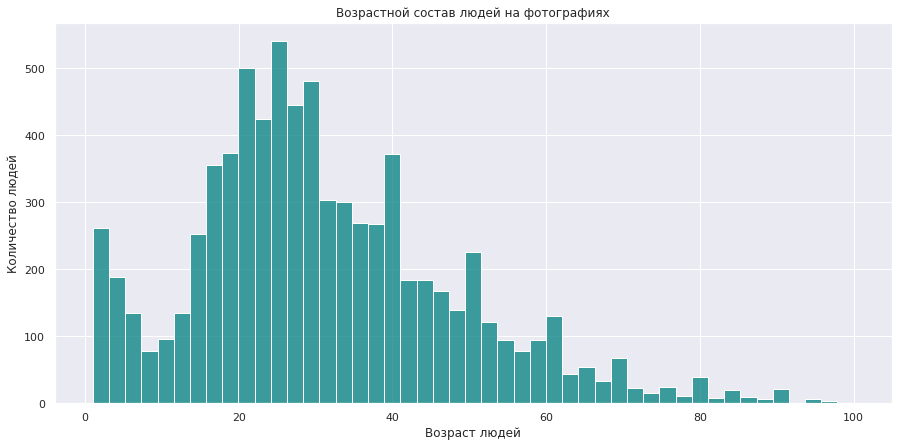

In [5]:
# смотрим, что с возрастом людей
sns.set(rc={'figure.figsize': (15, 7)})
ax = sns.histplot(data=labels, x='real_age', color='teal')
ax.set(title='Возрастной состав людей на фотографиях', \
       xlabel='Возраст людей', ylabel='Количество людей');
print(labels.real_age.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.8, 0.95]))

На фотографиях люди встречаются от 1 года до 100 лет. Это правдоподобно. Основная масса людей на фотографиях в возрасте от 15 до 50 лет. Есть довольно много фотографий малей и малышек в возрасте до 2 лет. Люди в возасте от 80 лет встречаются редко. Это связано с возрастом дожития до таких лет.

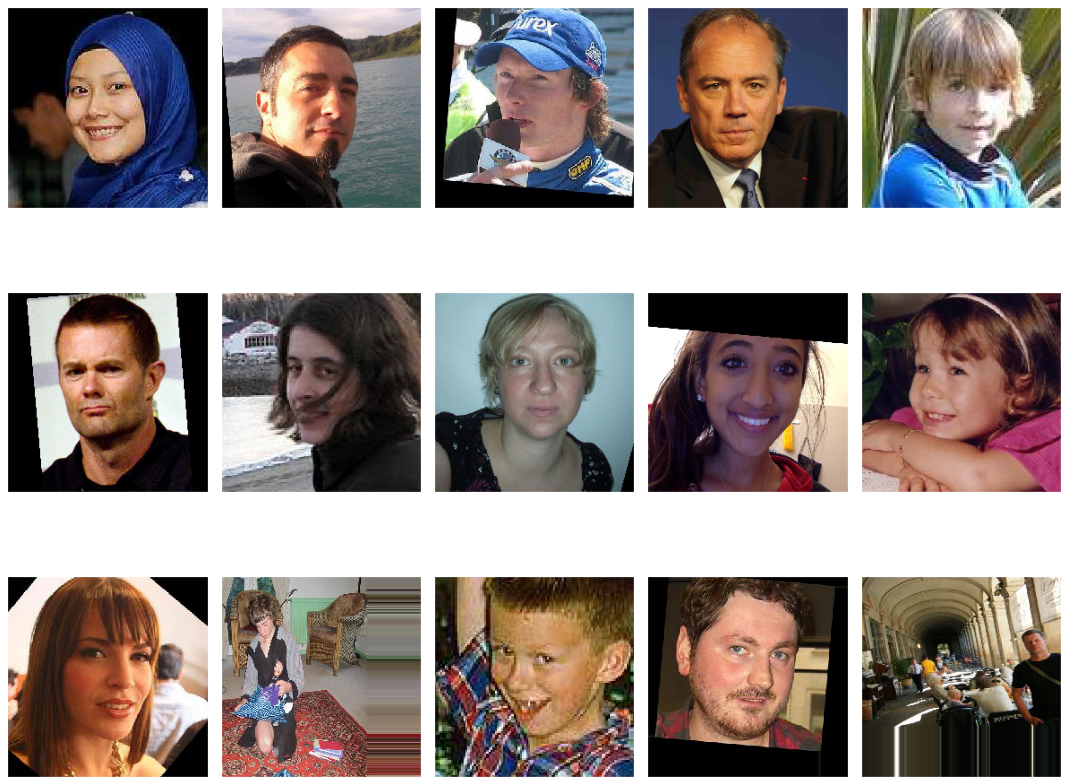

In [7]:
features, target = next(train_datagen_flow)
# печатаем несколько фотографий для примера
fig = plt.figure(figsize=(15,15))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Фотографии есть самые разные: и на полный кадр, и подрезанные, и и наклонённые, и повёрнутые. Это значит, что при подготовке модели эти особенности надо будет учесть для достижения лучшего результата.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense,  AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def load_train(path):
    labels_df = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25
        , horizontal_flip=True
        , vertical_flip=True 
        , rotation_range=90 
        , width_shift_range=0.2 
        , height_shift_range=0.2  
        , rescale=1/255.)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123)
    return train_datagen_flow

def load_test(path):
    labels_df = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123)
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_absolute_error', 
              optimizer=optimizer, metrics=['mean_absolute_error'])
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=36,
               steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/36
2023-11-26 12:10:51.470043: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-11-26 12:10:52.663855: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 115s - loss: 13.8764 - mean_absolute_error: 13.8770 - val_loss: 15.5626 - val_mean_absolute_error: 15.4470
Epoch 2/36
178/178 - 92s - loss: 9.5954 - mean_absolute_error: 9.5947 - val_loss: 18.8186 - val_mean_absolute_error: 18.6917
Epoch 3/36
178/178 - 92s - loss: 8.8258 - mean_absolute_error: 8.8250 - val_loss: 13.2186 - val_mean_absolute_error: 13.1592
Epoch 4/36
178/178 - 91s - loss: 8.4586 - mean_absolute_error: 8.4581 - val_loss: 10.7068 - val_mean_absolute_error: 10.6594
Epoch 5/36
178/178 - 92s - loss: 8.0834 - mean_absolute_error: 8.0829 - val_loss: 8.8294 - val_mean_absolute_error: 8.8499
Epoch 6/36
178/178 - 92s - loss: 7.9178 - mean_absolute_error: 7.9172 - val_loss: 11.4124 - val_mean_absolute_error: 11.3034
Epoch 7/36
178/178 - 91s - loss: 7.7430 - mean_absolute_error: 7.7423 - val_loss: 8.6226 - val_mean_absolute_error: 8.5482
Epoch 8/36
178/178 - 92s - loss: 7.3936 - mean_absolute_error: 7.3931 - val_loss: 8.9659 - val_mean_absolute_error: 8.9644
Epoch 9/36
178/178 - 95s - loss: 7.3187 - mean_absolute_error: 7.3177 - val_loss: 7.4880 - val_mean_absolute_error: 7.4845
Epoch 10/36
178/178 - 100s - loss: 7.1237 - mean_absolute_error: 7.1237 - val_loss: 7.9987 - val_mean_absolute_error: 7.9777
Epoch 11/36
178/178 - 93s - loss: 6.9245 - mean_absolute_error: 6.9240 - val_loss: 7.6966 - val_mean_absolute_error: 7.7421
Epoch 12/36
178/178 - 94s - loss: 6.6789 - mean_absolute_error: 6.6784 - val_loss: 7.9574 - val_mean_absolute_error: 7.8865
Epoch 13/36
178/178 - 93s - loss: 6.6538 - mean_absolute_error: 6.6534 - val_loss: 7.6782 - val_mean_absolute_error: 7.6337
Epoch 14/36
178/178 - 99s - loss: 6.6271 - mean_absolute_error: 6.6264 - val_loss: 8.2006 - val_mean_absolute_error: 8.1479
Epoch 15/36
178/178 - 93s - loss: 6.3605 - mean_absolute_error: 6.3595 - val_loss: 10.5223 - val_mean_absolute_error: 10.5486
Epoch 16/36
178/178 - 93s - loss: 6.3566 - mean_absolute_error: 6.3560 - val_loss: 7.3131 - val_mean_absolute_error: 7.2486
Epoch 17/36
178/178 - 93s - loss: 6.1604 - mean_absolute_error: 6.1600 - val_loss: 7.8210 - val_mean_absolute_error: 7.8114
Epoch 18/36
178/178 - 94s - loss: 6.0669 - mean_absolute_error: 6.0664 - val_loss: 8.2975 - val_mean_absolute_error: 8.3229
Epoch 19/36
178/178 - 93s - loss: 5.9151 - mean_absolute_error: 5.9147 - val_loss: 7.5664 - val_mean_absolute_error: 7.5402
Epoch 20/36
178/178 - 94s - loss: 5.9626 - mean_absolute_error: 5.9619 - val_loss: 7.7082 - val_mean_absolute_error: 7.5993
Epoch 21/36
178/178 - 93s - loss: 5.9010 - mean_absolute_error: 5.9002 - val_loss: 7.3084 - val_mean_absolute_error: 7.2444
Epoch 22/36
178/178 - 94s - loss: 5.6310 - mean_absolute_error: 5.6306 - val_loss: 7.0696 - val_mean_absolute_error: 7.0571
Epoch 23/36
178/178 - 93s - loss: 5.6436 - mean_absolute_error: 5.6430 - val_loss: 9.2423 - val_mean_absolute_error: 9.2156
Epoch 24/36
178/178 - 92s - loss: 5.4651 - mean_absolute_error: 5.4643 - val_loss: 7.1586 - val_mean_absolute_error: 7.1371
Epoch 25/36
178/178 - 94s - loss: 5.4749 - mean_absolute_error: 5.4745 - val_loss: 7.2729 - val_mean_absolute_error: 7.3025
Epoch 26/36
178/178 - 93s - loss: 5.4395 - mean_absolute_error: 5.4386 - val_loss: 7.6649 - val_mean_absolute_error: 7.6715
Epoch 27/36
178/178 - 92s - loss: 5.3868 - mean_absolute_error: 5.3863 - val_loss: 7.0625 - val_mean_absolute_error: 7.0346
Epoch 28/36
178/178 - 93s - loss: 5.2459 - mean_absolute_error: 5.2452 - val_loss: 6.9672 - val_mean_absolute_error: 6.9528
Epoch 29/36
178/178 - 93s - loss: 5.0732 - mean_absolute_error: 5.0728 - val_loss: 7.6903 - val_mean_absolute_error: 7.6527
Epoch 30/36
178/178 - 93s - loss: 5.0850 - mean_absolute_error: 5.0845 - val_loss: 8.0839 - val_mean_absolute_error: 8.0979
Epoch 31/36
178/178 - 91s - loss: 5.0154 - mean_absolute_error: 5.0149 - val_loss: 7.4452 - val_mean_absolute_error: 7.4453
Epoch 32/36
178/178 - 94s - loss: 4.9062 - mean_absolute_error: 4.9058 - val_loss: 7.0528 - val_mean_absolute_error: 7.0597
Epoch 33/36
178/178 - 94s - loss: 4.8675 - mean_absolute_error: 4.8668 - val_loss: 7.6041 - val_mean_absolute_error: 7.5723
Epoch 34/36
178/178 - 94s - loss: 4.8099 - mean_absolute_error: 4.8098 - val_loss: 7.6605 - val_mean_absolute_error: 7.6447
Epoch 35/36
178/178 - 94s - loss: 4.7190 - mean_absolute_error: 4.7187 - val_loss: 8.1979 - val_mean_absolute_error: 8.1870
Epoch 36/36
178/178 - 94s - loss: 4.6815 - mean_absolute_error: 4.6809 - val_loss: 7.2943 - val_mean_absolute_error: 7.3172
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 7.2943 - mean_absolute_error: 7.3172
Test MAE: 7.3172


```

## Анализ обученной модели

Мы получили неплохо обученную модель, которая хорошо предсказывает возраст людей. Эта модель оказалась достаточно неплохой - у нашей модели МАЕ на валидации - 7.3172. По заданию нужно поучить метрику МАЕ на валидации меньше 8, что соотвествует задаче.